In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
results = pd.read_csv('../outputs/chunked_results.csv')

In [56]:
results = results[(results.model_name.isin(['gpt-4o-2024-05-13', 'gpt-4o-mini-2024-07-18']) & (results.task == 'demographics-zeroshot'))]
results['strategy'] = results.apply(lambda row: f"{row['min_chars']}_{row['max_chars']}", axis=1)

/tmp/ipykernel_347546/1551223243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['strategy'] = results.apply(lambda row: f"{row['min_chars']}_{row['max_chars']}", axis=1)


In [58]:
full = pd.read_csv('../outputs/full_results.csv')
full = full[full.n_studies == 283]
full['strategy'] = 'full'

In [59]:
results = pd.concat([results, full])

/home/zorro/anaconda3/envs/llm-predict/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


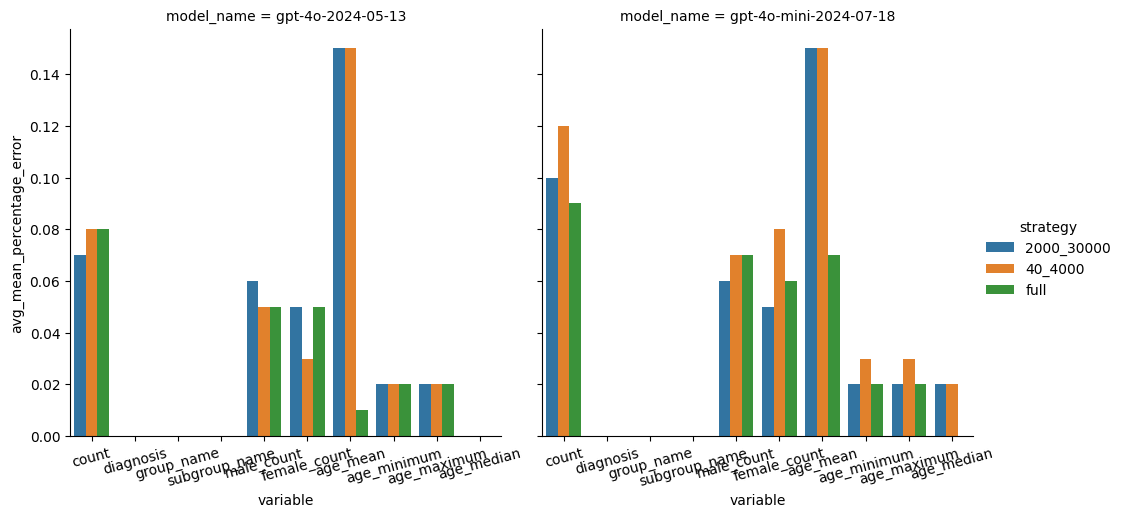

In [69]:
g = sns.catplot(data=results, x='variable', y='avg_mean_percentage_error', kind='bar', hue='strategy', col='model_name', legend='full')
g.set_xticklabels(rotation=15)

/home/zorro/anaconda3/envs/llm-predict/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


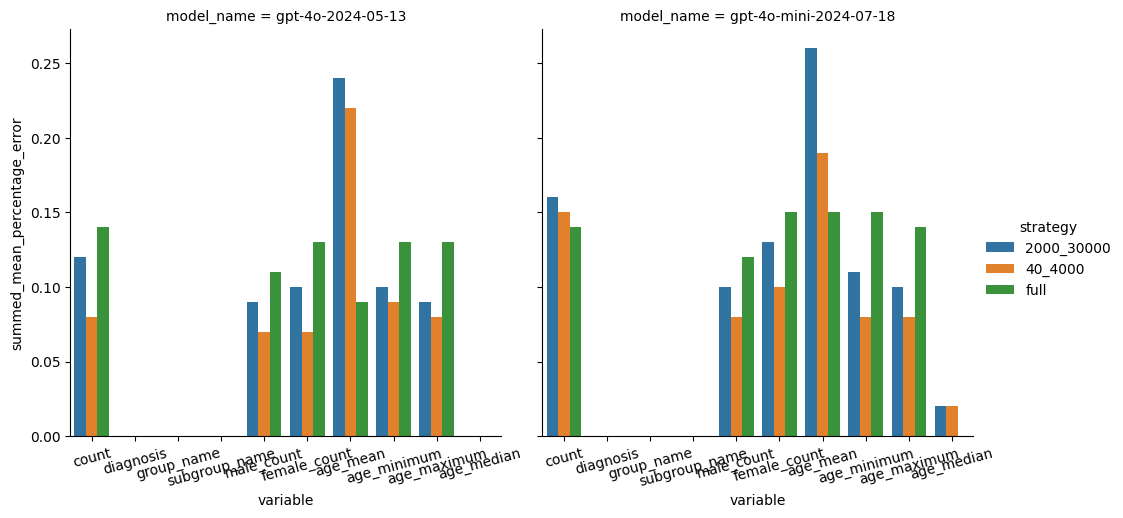

In [72]:
g = sns.catplot(data=results, x='variable', y='summed_mean_percentage_error', kind='bar', hue='strategy', col='model_name', legend='full')
g.set_xticklabels(rotation=15)

/home/zorro/anaconda3/envs/llm-predict/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


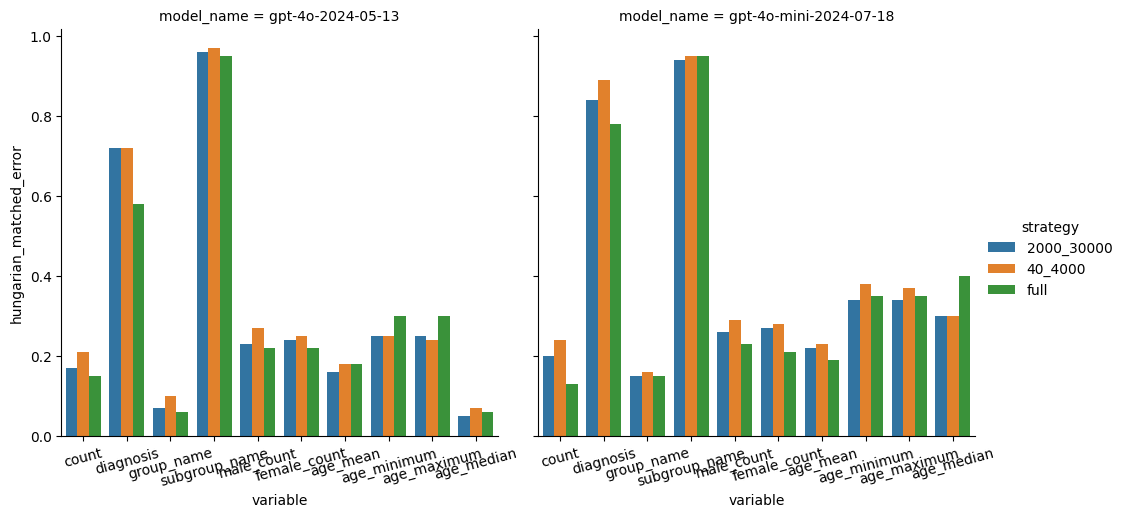

In [73]:
g = sns.catplot(data=results, x='variable', y='hungarian_matched_error', kind='bar', hue='strategy', col='model_name', legend='full')
g.set_xticklabels(rotation=15)

For both GPT 4o and GPT 4o-mini there was minimal difference between chunking strategy and using the full HTML as input

### Cost analysis

Estimate number of tokens in a large set of articles, html etc.. 

In [108]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4o")

In [109]:
## 2000 articles as represntative sample
full_text = pd.read_csv('../data/pubget_searches/query_953be51911e9f62884cbc03b0ac4f919/subset_articlesWithCoords_extractedData/text.csv')

In [116]:
n_tokens = []
for text in full_text['body'].to_list():
    n_tokens.append(len(enc.encode(text)))

n_tokens = pd.Series(n_tokens)

In [118]:
n_tokens.describe()

count      467.000000
mean      8018.055675
std       2933.655693
min       3009.000000
25%       6145.000000
50%       7406.000000
75%       9083.500000
max      23892.000000
dtype: float64

<Axes: >

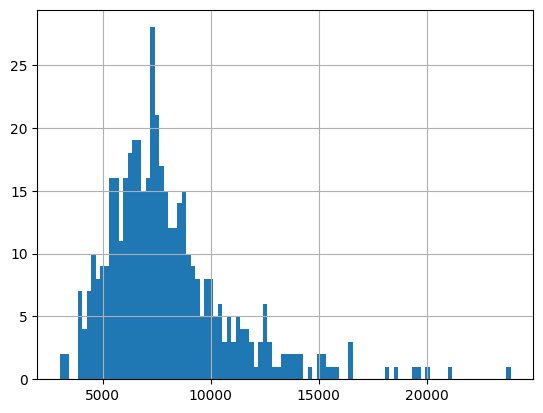

In [119]:
n_tokens.hist(bins=100)

### Try chunking to see new size

In [121]:
from publang.utils.split import split_pmc_document

In [145]:
## Combine the previous code into a single for loop, storing results for 3 different strategies in a single dataframe

results = pd.DataFrame(columns=['strategy', 'n_tokens'])

for min_chars, max_chars in [(40, 4000), (2000, 30000)]:    
    tokens = []
    for text in full_text['body'].to_list():
        for t in split_pmc_document(text, min_chars=min_chars, max_chars=max_chars):
            tokens.append(len(enc.encode(t['content'])))

    results = pd.concat([results, pd.DataFrame({'strategy': f"{min_chars}_{max_chars}", 'n_tokens': tokens})])
    
# Without chunking
tokens = []
for text in full_text['body'].to_list():
    tokens.append(len(enc.encode(text)))

results = pd.concat([results, pd.DataFrame({'strategy': 'full', 'n_tokens': tokens})])

<Axes: xlabel='strategy', ylabel='n_tokens'>

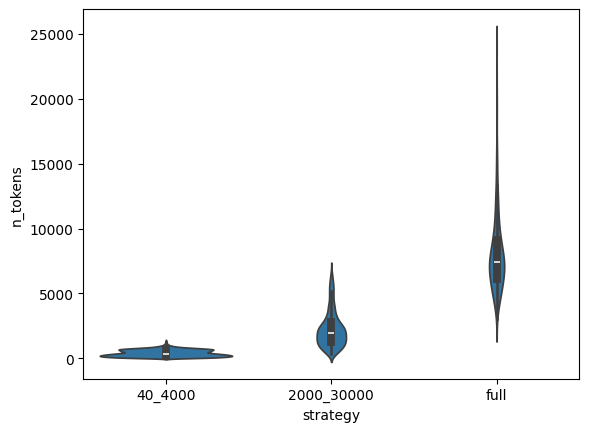

In [147]:
# Plot all 3 distributions in a single violin plot
sns.violinplot(data=results, x='strategy', y='n_tokens')

In [158]:
results['n_tokens'] = results.n_tokens.astype(int)

In [159]:
# Describe the distributions (mean, std, min, max, etc.)
results.groupby('strategy').describe()

n_tokens                                                            \
              count         mean          std     min     25%     50%     75%   
strategy                                                                        
2000_30000   1647.0  2249.501518  1371.538698   346.0  1255.5  1979.0  2824.0   
40_4000      9183.0   408.587608   252.917637     1.0   193.0   370.0   616.0   
full          467.0  8018.055675  2933.655693  3009.0  6145.0  7406.0  9083.5   

                     
                max  
strategy             
2000_30000   6752.0  
40_4000      1347.0  
full        23892.0

### Compute cost

In [179]:
# At GPT 4o mini's current token cost of $0.150 / 1M input tokens and GPT 4o's cost of $5.00 / 1M

results['gpt_4o-mini-cost'] = results.apply(lambda row: row['n_tokens'] * 0.150 / 1000000, axis=1)
results['gpt_4o-cost'] = results.apply(lambda row: row['n_tokens'] * 5 / 1000000, axis=1)
results['gpt-4-32k-cost'] = results.apply(lambda row: row['n_tokens'] * 60 / 1000000, axis=1)

In [180]:
# Cost per 10,000 articles
results.groupby('strategy')['gpt_4o-cost'].mean() * 10000

strategy
2000_30000    112.475076
40_4000        20.429380
full          400.902784
Name: gpt_4o-cost, dtype: float64

In [186]:
400 / 20

20.0

In [181]:
results.groupby('strategy')['gpt_4o-mini-cost'].mean() * 10000

strategy
2000_30000     3.374252
40_4000        0.612881
full          12.027084
Name: gpt_4o-mini-cost, dtype: float64

Using chunking can save a significant amont of money, although with GPT 4o mini, the cost is already quite low.

The cost with chunking is realistically 2-3x as much, since the wrong chunk may be fed in, which requires passing in multiple chunks, and correct chunks are on average larger. 
In addition, chunks suffer from lack of context, meaning passing title + abstract is reasonable for disease ontology. 

As such with *GPT 4o* costs with chunking are likely to be ~$50 per 10,000, vs $400 per 10,000 using whole paper.
With whole paper, batch processing could cut cost in 1/2, reducing this to $200. 

Next, let's estimate if GPT 4o mini does well on disease ontology task

In [184]:
# For fun this would have been the cost with original GPT 4 model:
results.groupby('strategy')['gpt-4-32k-cost'].mean() * 10000

strategy
2000_30000    1349.700911
40_4000        245.152565
full          4810.833405
Name: gpt-4-32k-cost, dtype: float64

In [187]:
1000000 / 8000

125.0